## Import needed packages

### Utility packages

In [1]:
import pandas as pd
import seaborn as sns
import zipfile
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.ndimage import rotate, shift
from mpl_toolkits.mplot3d import Axes3D

### Machine learning packages

In [2]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Reshape, Flatten, Dense, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from visualkeras import layered_view
from sklearn.utils import shuffle
from skimage.util import random_noise
from tensorflow.keras import models, utils, optimizers, layers
import tensorflow as tf
from tensorflow.keras import models, utils, optimizers, layers
from sklearn.decomposition import PCA

## Tensorflow configuration for Apple M1 Pro

I'm training this model on an M1 MacBook Pro, which means I can take advantage of Apple's Metal graphical API to make training GPU-bound instead of CPU-bound. Note that this requires the `tensorflow-metal` and `tensorflow-macos` packages. 

I'm adding the GPU as a device below. 

In [3]:
tf.config.experimental.set_visible_devices(tf.config.list_physical_devices('GPU'), 'GPU')
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Extract and store data

First, we need to unzip the data and store all datasets in a Pandas dataframe, allowing us to transform the data en masse. 

The sign MNIST dataset includes training and test datasets; each of these will be stored in its own dataframe.

In [4]:
with zipfile.ZipFile('data/sign.zip') as data_zip:
    data_zip.extractall('data/')

training = pd.read_csv("data/sign_mnist_train/sign_mnist_train.csv")
testing = pd.read_csv("data/sign_mnist_test/sign_mnist_test.csv")

## Exploring the data

Let's see what the data generally looks like...
The dataset in its current form uses **numerical indexes for given signs**.  

The numbers are indexes for letters of the alphabet (.e.g the sign for A has a "label" column value of 0). 


In [5]:
training.head(10)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
5,16,161,168,172,173,178,184,189,193,196,...,76,74,68,62,53,55,48,238,255,255
6,8,134,134,135,135,136,137,137,138,138,...,109,102,91,65,138,189,179,181,181,179
7,22,114,42,74,99,104,109,117,127,142,...,214,218,220,223,223,225,227,227,228,228
8,3,169,174,176,180,183,185,187,188,190,...,119,118,123,120,118,114,94,74,61,57
9,3,189,189,189,190,190,191,190,190,190,...,13,53,200,204,201,201,193,175,178,156


In [6]:
unique_labels = sorted(training['label'].unique())
label_map = {label: i for i, label in enumerate(unique_labels)}

training['label'] = training['label'].map(label_map)
testing['label'] = testing['label'].map(label_map)

In [7]:
training.loc[training["label"] == 24]

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784


### Labelling the data
We'll create a "sign column" to translate the index into the appropriate letter sign to make things more intuitive for us humans.

In [8]:
# alphabet_unfiltered = {idx:chr(i) for idx, i in enumerate(range(ord('a'), ord('z') + 1))} ## get letters in alphabetical order
alphabet_unindexed = {idx: chr(i) for idx, i in enumerate(range(ord('a'), ord('y') + 1)) if chr(i) != "j"}

## remove signs not included in dataset
alphabet = {i:v for i, (k, v) in enumerate(alphabet_unindexed.items()) if (v != "z" and v!= "j")}

# create a new col ("sign"), which will include the letter represented by the "label" column
training["sign"] = training["label"].map(alphabet)
testing["sign"] = testing["label"].map(alphabet)

In [9]:
print(alphabet)

{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'k', 10: 'l', 11: 'm', 12: 'n', 13: 'o', 14: 'p', 15: 'q', 16: 'r', 17: 's', 18: 't', 19: 'u', 20: 'v', 21: 'w', 22: 'x', 23: 'y'}


### Getting the amount of data

How many images are in the training and testing datasets?

In [10]:
print(f"Training data: \ncolumns: {training.shape[0]} \nrows: {training.shape[1]}")

Training data: 
columns: 27455 
rows: 786


In [11]:
print(f"Training data: \ncolumns: {testing.shape[0]} \nrows: {testing.shape[1]}")

Training data: 
columns: 7172 
rows: 786


The training data contains over 27,000 examples of sign language symbols. Considering that there's only 26 letters of the English alphabet, that's a lot of training depth. 

If we remove the "label" and "sign" columns, we are left with 784 columns, 1 for each pixel of the image. The math checks out, as the images are 28x28 pixels, or 784.

### Viewing the images 

To ensure accurate training of the model, we need to know what the images look like. Let's render a few of the images from their pixel values and plot them in a quick grid.

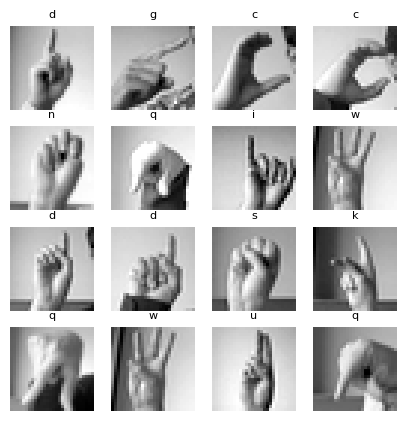

In [12]:
## look at just 6 images 
cols = 4 # cols
rows = 4

pics = np.array(training[:rows*cols].drop(columns=["label", "sign"]))
pics = np.reshape(pics, (pics.shape[0], 28,28))

fig, axs = plt.subplots(rows,cols, figsize=(5, 5))
indx = 0
for i in range(rows):
    for j in range(cols):
        axs[i,j].imshow(pics[indx], interpolation='nearest', cmap='gray')
        axs[i,j].axis('off')
        label = alphabet[training[:rows*cols]['label'][indx]]
        axs[i,j].set_title(f'{label}', fontsize=8)
        indx += 1
plt.show()


The images all seem to share a common background, and are right-side up. None of them appear to be noisy. In short, they're a little too perfect for real-world data.

### Distribution of signs in data

To ensure the model doesn't favor one sign over others, all signs in the dataset should be of relatively equal distribution. Let's check this using a simple barplot

<Axes: xlabel='Sign', ylabel='Frequency'>

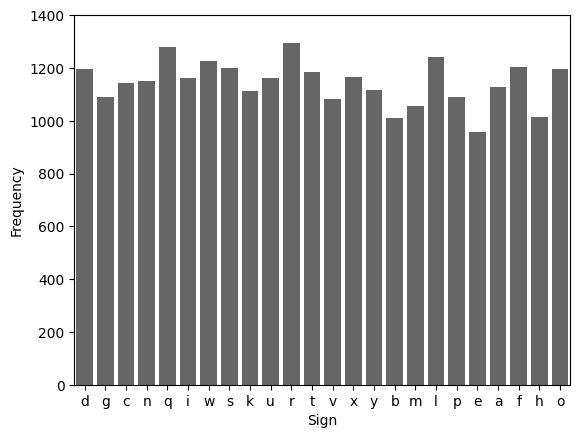

In [13]:
dists = sns.countplot(data = training, x = "sign", color = "black", alpha = 0.6)
dists.set(ylabel = "Frequency", xlabel = "Sign")
dists.set_ylim(0, 1400)
dists

All the signs are represented to similar levels, with no glaring discrepancies/outliers. The ability of the model to recognize "e" signs should be considered, as it is the least-represented sign in the dataset, though not by a wide margin.

### do the signs overlap in pixel data?

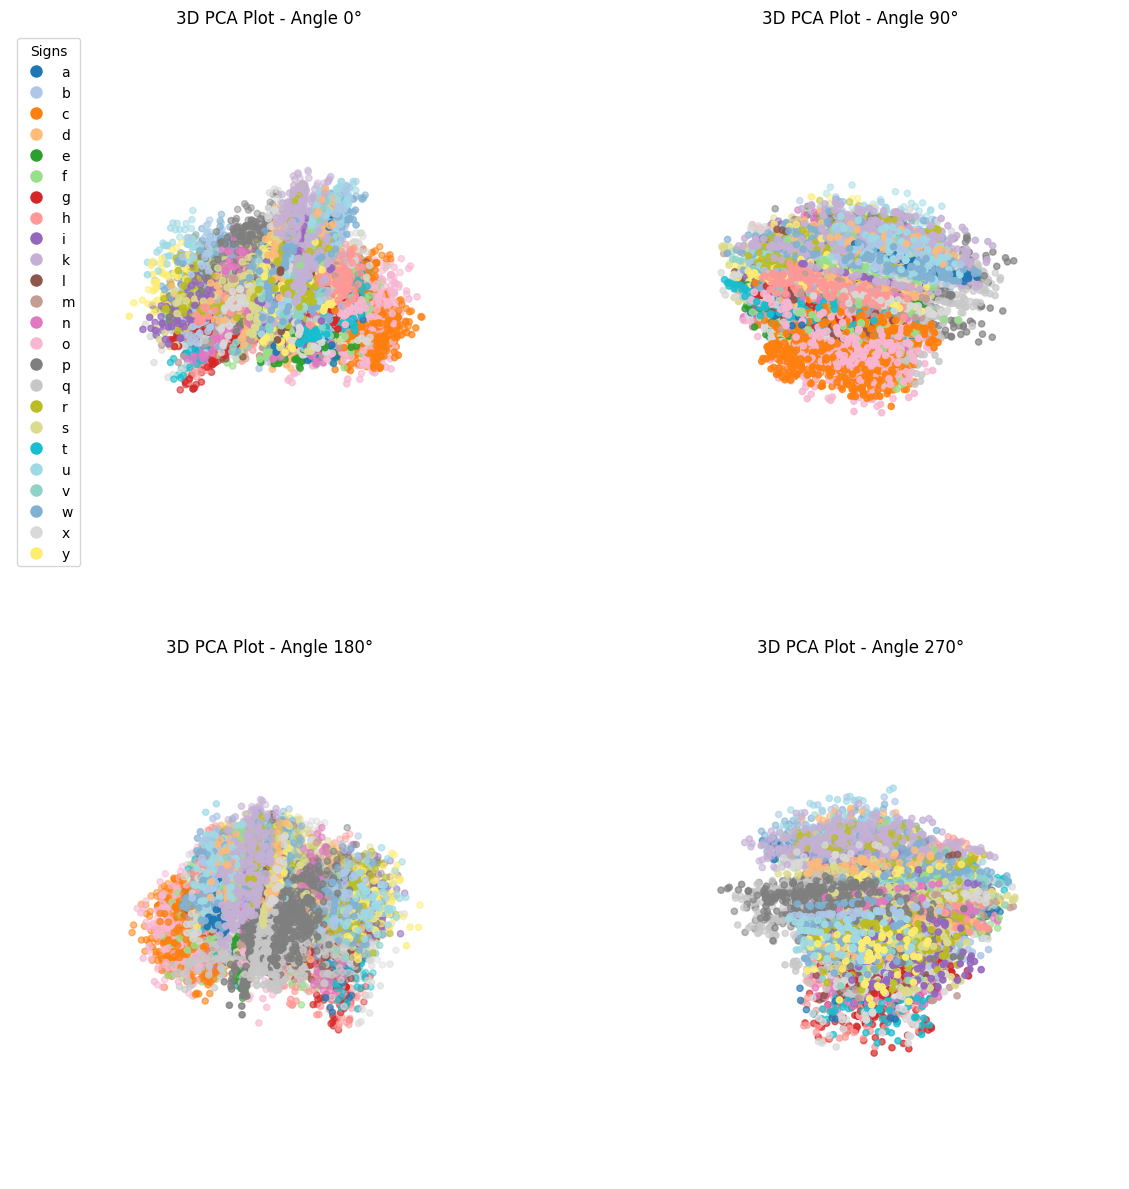

In [14]:
decompress = PCA(n_components = 3)
n3 = decompress.fit_transform(training.drop(columns = ["label", "sign"]))

x = n3[:, 0]
y = n3[:, 1]
z = n3[:, 2]

labels = np.asarray([sign for sign in training["label"]])

# unique_labels = np.unique(labels)
unique_labels = list(alphabet.keys())
label_to_num = {label: num for num, label in enumerate(unique_labels)}
numeric_labels = np.array([label_to_num[label] for label in labels])

# make a custom colormap varied enough for the 24 distinct signs
n_categories = len(unique_labels)
colors = plt.cm.tab20(np.linspace(0, 1, 20))  # Get 20 colors from tab20
colors = np.vstack((colors, plt.cm.Set3(np.linspace(0, 1, 4))))  # Add 4
cmap = ListedColormap(colors)
norm = BoundaryNorm(np.arange(-0.5, n_categories, 1), cmap.N)

# Create a 2x2 grid of subplots, since we have 4 rotated versions of the main figure
fig, axs = plt.subplots(2, 2, figsize=(12, 12), subplot_kw={'projection': '3d'})
axs = axs.flatten()  # Flatten the 2D array of axes to 1D for easy iteration

for i, angle in enumerate(range(0, 360, 90)):
    ax = axs[i]
    
    # plot
    scatter = ax.scatter(xs=x, ys=y, zs=z, c=numeric_labels, cmap=cmap, norm=norm, marker='o')
    
    # add legend to first plot
    if i == 0:
        # Create custom legend
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                      markerfacecolor=cmap(norm(num)), 
                                      markersize=10, label=alphabet[num])
                           # for num in range(n_categories)]
                           for num in unique_labels]
        ax.legend(handles=legend_elements, loc="upper left", title="Signs")
    
    # we don't need axis or grid lines for this
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.grid(False)
    ax.axis("off")
    
    # rotate the 3d figure
    ax.view_init(30, angle)
    
    # title it by angle of rotation
    ax.set_title(f'3D PCA Plot - Angle {angle}°')

# display figure panels
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.show()

While the images for each sign don't vary from *each other* too much, there is crossover between *entirely different* signs, at least when limiting analysis to 3 components. 

In other words, all letter 'C's look pretty similar to each other, but can also look similar to another letter. 

We'll need to train the model to be adept enough to identify one letter to disqualify a similar letter. 

## Transforming data for model training 

In [15]:
# separate pixel data from labels, as the training function takes them in as separate arguments
alt_test = np.array(testing.drop(columns = ["label", "sign"]))
alt_train = np.array(training.drop(columns = ["label", "sign"]))

test_labels = np.array(testing["label"])
train_labels = np.array(training["label"])

# we don't need to load the older variables any more in memory, so drop them:
testing = None
training = None
pca = None
n3 = None

### Normalizing data for easier training

Values between 0 and 255 (the min and max of the pixel values of the original dataset) take up much more space in memory than values between 0 and 1. To enable faster training, pixel data will be normalized to a maximum value of 1.

In [16]:
def reshape_max(arr: np.array):
    arr = arr.T - arr.min(axis = 1) 
    arr = arr.T / arr.max(axis = 1)
    return arr

alt_test = reshape_max(alt_test)
alt_train = reshape_max(alt_train)

print(f"Training dataset\nmininum: {alt_train.min().min()}\nmaximum: {alt_train.max().max()}")
print("----------------")
print(f"Testing dataset\nmininum: {alt_test.min().min()}\nmaximum: {alt_test.max().max()}")

Training dataset
mininum: 0.0
maximum: 1.0
----------------
Testing dataset
mininum: 0.0
maximum: 1.0


### Reshaping data for easier training

Aside from the values in the training data, CNNs also consider the position of each data value in an array, which helps these models classify images and other 2d matrices so quickly. 

We can organize the pixel values for each image into a 2d array, creating a canvas of pixel values as they would be arranged in the original image. This would give the model this extra positional data, but would obviously increase the size of the training data.

In [17]:
alt_test = np.reshape(alt_test, (alt_test.shape[0], 28, 28, 1))
alt_train = np.reshape(alt_train, (alt_train.shape[0], 28, 28, 1))

### Making image labels categorical

The model may mistake the integer values used for labelling each image as belonging to a continuous scale, when they need to be treated as discrete values. Tensorflow has a function to make them categorical. 

In [18]:
test_labels = utils.to_categorical(test_labels, num_classes = 24)
train_labels = utils.to_categorical(train_labels, num_classes = 24)

### Adding synthetic data variants for training

In [19]:
SEED = 101
tf.random.set_seed(SEED)

def add_synthetic_data(data, labels):
    new_data = data
    new_labels = labels
    resize_factors = [22, 18]
    
    # Original resizing
    for scale in resize_factors:
        new = tf.image.resize(data, [scale, scale])
        new = tf.image.resize_with_crop_or_pad(new, 28, 28)
        new_data = np.append(new_data, new, axis=0)
        new_labels = np.append(new_labels, labels, axis=0)

    # Mirroring
    mirrored = tf.image.flip_left_right(data)
    new_data = np.append(new_data, mirrored, axis=0)
    new_labels = np.append(new_labels, labels, axis=0)

    # Invert the colors of half the images
    new_data, new_labels = shuffle(new_data, new_labels, random_state=SEED)
    new_data = (new_data - 1) * -1

    # Add noise to the training set
    new_data = random_noise(new_data, mode='s&p', amount=0.05, rng=SEED)
    new_data, new_labels = shuffle(new_data, new_labels, random_state=SEED)
    
    return new_data, new_labels


In [20]:
alt_test, test_labels = add_synthetic_data(alt_test, test_labels)
alt_train, train_labels = add_synthetic_data(alt_train, train_labels)

2024-08-01 19:38:46.356309: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-08-01 19:38:46.356332: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-08-01 19:38:46.356338: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-08-01 19:38:46.356361: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-01 19:38:46.356375: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [21]:
print(alt_train.shape)
print(train_labels.shape)
print("------------")
print(alt_test.shape)
print(test_labels.shape)

(109820, 28, 28, 1)
(109820, 24)
------------
(28688, 28, 28, 1)
(28688, 24)


In [22]:
print("NaN in alt_train:", np.isnan(alt_train).any())
print("Inf in alt_train:", np.isinf(alt_train).any())


NaN in alt_train: False
Inf in alt_train: False


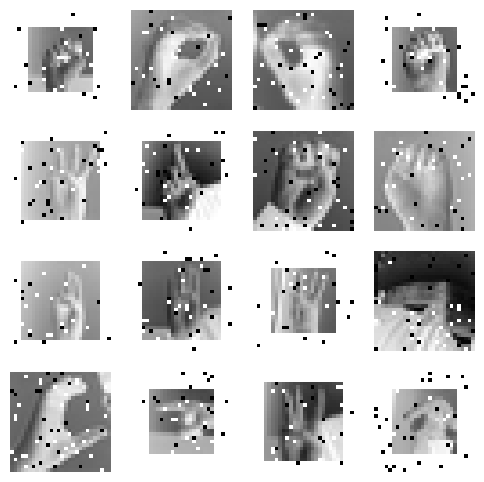

In [23]:
fig, axs = plt.subplots(rows,cols, figsize=(6, 6))
indx = 1
for i in range(rows):
    for j in range(cols):
        axs[i,j].imshow(alt_train[indx], interpolation='nearest', cmap='gray')
        axs[i,j].axis('off')
        indx += 1
plt.show()

We now have ~110,000 training images with varying noise levels, backgrounds, and orientations!

## Building the model

The model is a sequential Convulotional Neural Network. Components are as follows: 

| Layer | Function | 
|------ | -------- |
| Input | Defines the shape of the input, which in this case is 1 28x28 array | 
| Conv2d | kernel-split feature-mapping of images, **core of the CNN** | 
| MaxPooling | extract features from feature-mapping round in a way that helps the entire image be scanned | 
| Dropout | prevent overfitting by resetting select neurons | 
| Dense | transform neuron data into output | 

In short, this model tries to be thorough with 3 convolutional layers over the data. However, this number of passes risks overtraining and hyperfixation on small features, which is why dropout and batch normalization are used, respectively. 

In [24]:
model = Sequential([
    Conv2D(128, (7, 7), input_shape = (28, 28, 1), activation = "relu"),
    MaxPooling2D(pool_size = (2, 2)), 
    Dropout(0.5), 

    Conv2D(128, (3, 3), activation = "relu"),
    MaxPooling2D(pool_size = (2, 2)), 
    Dropout(0.4), #0.4

    Conv2D(256, (3, 3), activation = "relu"),
    MaxPooling2D(pool_size = (2, 2)), 
    Dropout(0.2), 

    Flatten(),

    Dense(128, activation = "relu"), 
    Dense(24, activation = "softmax")
    ])

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


/Users/eli/tensor_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 22, 22, 128)    │         6,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 9, 9, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 485,144 (1.85 MB)

 Trainable params: 485,144 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history = model.fit(alt_train, train_labels, batch_size = 100, validation_data = (alt_test, test_labels), epochs=15, verbose = 1)

Epoch 1/15


2024-08-01 19:38:50.104380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1099/1099 ━━━━━━━━━━━━━━━━━━━━ 40s 35ms/step - accuracy: 0.0921 - loss: 3.0213 - val_accuracy: 0.4160 - val_loss: 1.8933
Epoch 2/15
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 40s 36ms/step - accuracy: 0.4444 - loss: 1.7395 - val_accuracy: 0.5837 - val_loss: 1.3001
Epoch 3/15
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - accuracy: 0.5959 - loss: 1.2237 - val_accuracy: 0.6749 - val_loss: 1.0112
Epoch 4/15
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 39s 36ms/step - accuracy: 0.6848 - loss: 0.9509 - val_accuracy: 0.7287 - val_loss: 0.8375
Epoch 5/15
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 40s 36ms/step - accuracy: 0.7351 - loss: 0.7842 - val_accuracy: 0.7670 - val_loss: 0.7158
Epoch 6/15
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - accuracy: 0.7771 - loss: 0.6566 - val_accuracy: 0.7987 - val_loss: 0.6108
Epoch 7/15
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 39s 36ms/step - accuracy: 0.8084 - loss: 0.5656 - val_accuracy: 0.8189 - val_loss: 0.5500
Epoch 8/15
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 39s 36ms/step - accuracy: 0.8334 - loss: 0.49

Training completed with an accuracy of ~90% with 15 epochs. 

## Evaluating/Testing performance

### Accuracy and Loss with ~160,000 images

Looking at the history of training, model accuracy increased and model loss decreased with each epoch, which is expected and suggests training is working. 

In this plot, we're looking at accuracy against the training dataset (Train) and the validation dataset (Validation). Accuracy reaches 90%+ for both, with the model performing more accurately with the validation dataset. This makes sense, as the validation dataset is much smaller than the training dataset, and thus has fewer opportunities for error by chance. 

Overall, the marked improvement in accuracy and loss suggests the training was effective. 

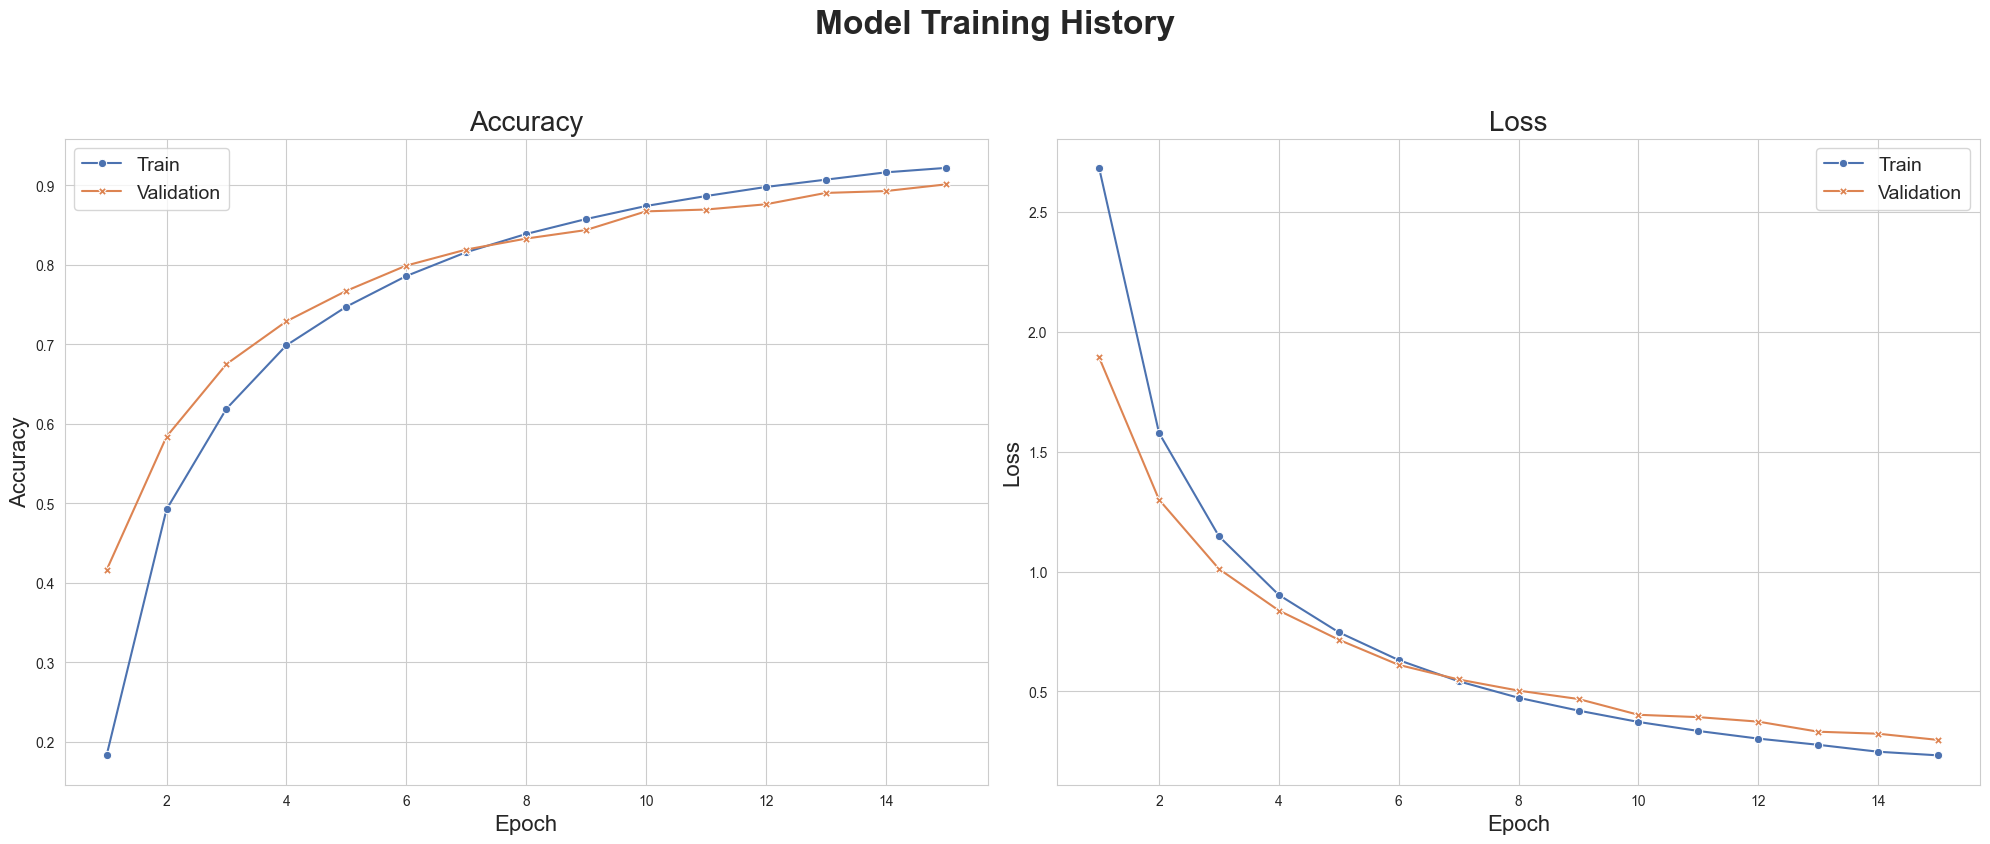

In [26]:
df = pd.DataFrame(history.history)
df['epoch'] = range(1, len(df) + 1)
df_melted = pd.melt(df, id_vars=['epoch'], value_vars=['accuracy', 'val_accuracy', 'loss', 'val_loss'],
                    var_name='metric', value_name='value')

sns.set_style("whitegrid")
sns.set_palette("deep")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Model Training History', fontsize=24, fontweight='bold', y=1.05)

sns.lineplot(data=df_melted[df_melted['metric'].isin(['accuracy', 'val_accuracy'])],
             x='epoch', y='value', hue='metric', style='metric', markers=True, dashes=False, ax=ax1)
ax1.set_title('Accuracy', fontsize=20)
ax1.set_ylabel('Accuracy', fontsize=16)
ax1.set_xlabel('Epoch', fontsize=16)

sns.lineplot(data=df_melted[df_melted['metric'].isin(['loss', 'val_loss'])],
             x='epoch', y='value', hue='metric', style='metric', markers=True, dashes=False, ax=ax2)  # Changed ax=2 to ax=ax2
ax2.set_title('Loss', fontsize=20)
ax2.set_ylabel('Loss', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=16)

for ax in [ax1, ax2]:
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], ['Train', 'Validation'], fontsize=14)
    
    for handle in handles[:2]:
        handle.set_linestyle('-')
        handle.set_marker('o')
        handle.set_markersize(8)
        handle.set_markerfacecolor(handle.get_color())

plt.tight_layout()
plt.show()

### Analyzing model weaknesses

One way to assess the weaknessses of the model, or, in this case, which signs it's prone to misclassify, we can plot the expected and test values in a confusion matrix and observe how close the expected calls are to the test values. 

The fewer values we see outside the diagonal blue line, the more accurate the model is.

897/897 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


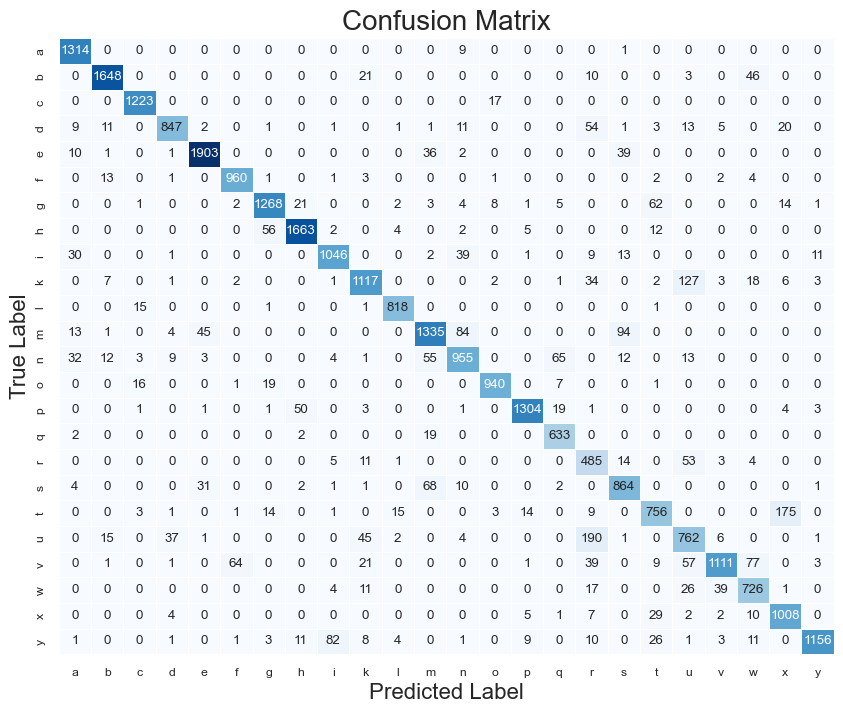

In [27]:
cm = confusion_matrix(y_true=np.argmax(test_labels, axis=1),
                      y_pred=np.argmax(model.predict(alt_test), axis=1))

new_alphabet = {k:v for k, v in alphabet.items() if (v != "j") and (v != "z")}

cm_df = pd.DataFrame(cm, index=new_alphabet.values(), columns=new_alphabet.values())

plt.figure(figsize=(10, 8))
sns.set(font_scale=0.8)
ax = sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=.5)


ax.set_xlabel('Predicted Label', fontsize=16)
ax.set_ylabel('True Label', fontsize=16)
ax.set_title('Confusion Matrix', fontsize=20)

plt.show()

Overall, the model peforms very well. The biggest source of confusion is comparing the "u" sign to the "r" sign, and the "x" sign to the "t" sign. Generally speaking, this model appears ready for use.

## Model testing

In [28]:
def predict_sign_language(model, image_path):
    # Load and preprocess the image
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    img = img.resize((28, 28))  
    
    img_array = np.array(img) / 255.0  # Normalize to [0, 1]
    img_array = img_array.reshape(1, 28, 28, 1)  # Reshape for model input

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    alphabet = 'ABCDEFGHIKLMNOPQRSTUVWXY'
    predicted_letter = alphabet[predicted_class]

    plt.imshow(img, cmap='gray')
    plt.title(f'Predicted Sign: {predicted_letter}')
    plt.axis('off')
    plt.show()

    print("Prediction probabilities:")
    for i, prob in enumerate(prediction[0]):
        if prob > 0.01:  # Only print probabilities > 1%
            print(f"{alphabet[i]}: {prob*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


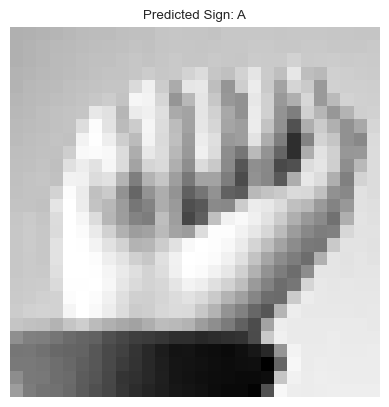

Prediction probabilities:
A: 73.86%
F: 1.15%
I: 5.71%
L: 9.84%
P: 4.36%
Y: 4.42%


In [35]:
predict_sign_language(model, "test_imgs/test2.png")

In [30]:
prediction = model.predict(alt_test)

897/897 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


Predicted Label:  h
True Label:  h


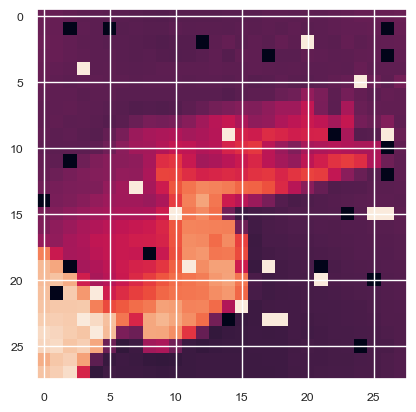

In [31]:
plt.imshow(alt_test[50,:,:,0]) 
print("Predicted Label: ", alphabet[int(np.argmax(prediction[50]))])
print("True Label: ", alphabet[int(np.argmax(test_labels[50]))])

Predicted Label:  c
True Label:  c


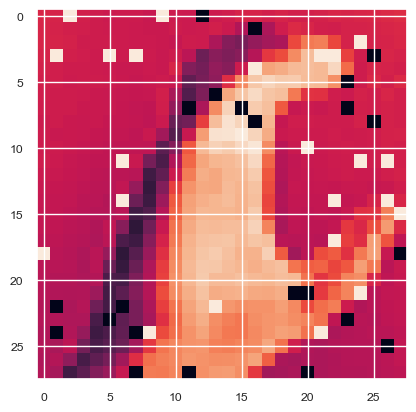

In [32]:
plt.imshow(alt_test[848,:,:,0]) 
print("Predicted Label: ", alphabet[int(np.argmax(prediction[848]))])
print("True Label: ", alphabet[int(np.argmax(test_labels[848]))])

Predicted Label:  e
True Label:  e


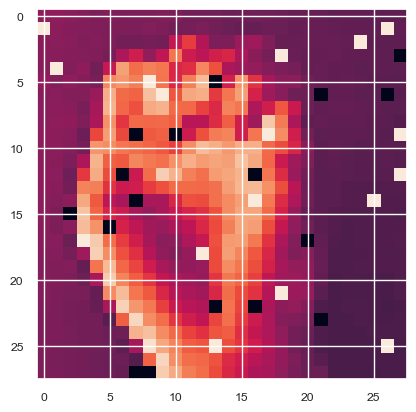

In [33]:
plt.imshow(alt_test[5840,:,:,0]) 
print("Predicted Label: ", alphabet[int(np.argmax(prediction[5840]))])
print("True Label: ", alphabet[int(np.argmax(test_labels[5840]))])